In [1]:
import findspark
findspark.init()

import pyspark


In [2]:
spark = pyspark.sql.SparkSession.builder \
     .master("local") \
     .appName("Word Count") \
     .config("spark.some.config.option", "some-value") \
     .getOrCreate()
sc = spark.sparkContext

### Projeto da mozilla pra monitoramento: https://github.com/mozilla/jupyter-spark

In [3]:
sc.uiWebUrl # ou spark.sparkContext.uiWebUrl

'http://10.2.96.44:4040'

In [4]:
df_d = spark.read.csv(
    "/Users/diogo.munaro/learn/tutorial-jupyter/dataset/despesa.csv", header=True, mode="DROPMALFORMED"
)
df_r = spark.read.csv(
    "/Users/diogo.munaro/learn/tutorial-jupyter/dataset/receita.csv", header=True, mode="DROPMALFORMED"
)

## Despesa

In [5]:
df_d.printSchema()

root
 |-- Exercicio: string (nullable = true)
 |-- Orgao: string (nullable = true)
 |-- Unidade_Orcamentaria: string (nullable = true)
 |-- Programa_de_Trabalho: string (nullable = true)
 |-- Acao: string (nullable = true)
 |-- Descricao_Acao: string (nullable = true)
 |-- Fonte_de_Recursos: string (nullable = true)
 |-- Descricao_Fonte: string (nullable = true)
 |-- Elemento_Despesa: string (nullable = true)
 |-- Descricao_Elemento: string (nullable = true)
 |-- Item_Despesa: string (nullable = true)
 |-- Descricao_item_Despesa: string (nullable = true)
 |-- Orcamento_Atualizado: string (nullable = true)
 |-- Empenhado: string (nullable = true)
 |-- Liquidado: string (nullable = true)
 |-- Pago: string (nullable = true)
 |-- Pago_Restos_Pagar: string (nullable = true)



In [6]:
df_d.count()

13510

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
def sanitize_valor(valor):
    return float(valor.replace(" ", "."))

udf_sanitize_valor=udf(sanitize_valor, FloatType())

In [8]:
df_d_new = df_d.withColumn('total', udf_sanitize_valor('Pago'))

In [9]:
from pyspark.sql.functions import desc

gastos = df_d_new.select("Acao", "Descricao_Acao", "total") \
    .groupBy("Acao", "Descricao_Acao") \
    .sum("total") \
    .orderBy(desc("sum(total)"))
gastos.show(truncate=False)

+----+---------------------------------------------------------------------------------+--------------------+
|Acao|Descricao_Acao                                                                   |sum(total)          |
+----+---------------------------------------------------------------------------------+--------------------+
|4300|SERVIDORES INATIVOS DA REDE DE ENSINO                                            |1.9422517606750488E9|
|2381|GASTOS COM PESSOAL - OBRIGACOES PATRONAIS E OUTROS BENEFICIOS - EDUCACAO         |1.6778572596716385E9|
|2562|PESSOAL DAS UNIDADES ESCOLARES - ENSINO FUNDAMENTAL                              |1.2769842251617432E9|
|2854|MANUTENCAO DO CUSTEIO DA REDE DE ATENCAO PRIMARIA A SAUDE                        |1.004418074720047E9 |
|2520|PROVISAO DE GASTOS COM PESSOAL - SAUDE                                           |9.848626756809692E8 |
|4525|PROVISAO DE GASTOS COM PESSOAL - ADM. INDIRETA - MEIO AMBIENTE E SUSTENTABILIDADE|9.485242772831573E8 |
|2389|GAST

In [87]:
gastos_pd = gastos.limit(20).toPandas()

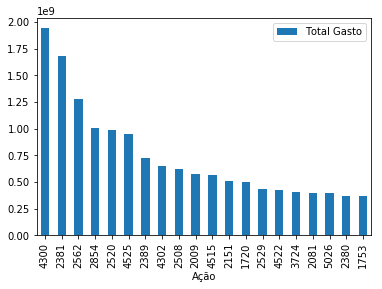

In [89]:
%matplotlib inline
gastos_pd.columns = ["Ação", "Descrição", "Total Gasto"]
gastos_pd.plot(x='Ação', y='Total Gasto', kind='bar')

In [12]:
df_d.select("Acao", "Descricao_Acao").distinct().show(truncate=False)

+----+------------------------------------------------------------------------------------------+
|Acao|Descricao_Acao                                                                            |
+----+------------------------------------------------------------------------------------------+
|2168|APOIO ADMINISTRATIVO - DESENVOLVIMENTO SOCIAL                                             |
|2736|MAPEAMENTO E GERENCIAMENTO DA MALHA VIARIA E DA MICRODRENAGEM DA CIDADE                   |
|2015|ADMINISTRACAO DAS OUVIDORIAS DO NIVEL CENTRAL  DAS CAPS E DOS HOSPITAIS                   |
|4341|DESPESAS OBRIGATORIAS E OUTROS CUSTEIOS - ADM. INDIRETA - EDUCACAO                        |
|8656|REFORMA DE QUADRA POLIESPORTIVA NO PREDIO DO CLUBE DOS SUBTENENTES E SARGENTOS BOMBEIROS D|
|2226|ATIVIDADES DO CONSELHO MUNICIPAL DE DEFESA DOS DIREITOS DA PESSOA COM DEFICIENCIA (COMDEF)|
|2114|PROMOVENDO A IGUALDADE RACIAL                                                             |
|2418|CONCESSIONARIA

## Receita

In [13]:
df_r.printSchema()

root
 |-- EXERCICIO: string (nullable = true)
 |-- DESC_ORGAO: string (nullable = true)
 |-- CODIGO_RUBRICA: string (nullable = true)
 |-- DESC_RUBRICA: string (nullable = true)
 |-- RECEITA_PREVISTA: string (nullable = true)
 |-- RECEITA_ARRECADADA: string (nullable = true)
 |-- RECEITA_ARRECADADA_JAN: string (nullable = true)
 |-- RECEITA_ARRECADADA_FEV: string (nullable = true)
 |-- RECEITA_ARRECADADA_MAR: string (nullable = true)
 |-- RECEITA_ARRECADADA_ABR: string (nullable = true)
 |-- RECEITA_ARRECADADA_MAI: string (nullable = true)
 |-- RECEITA_ARRECADADA_JUN: string (nullable = true)
 |-- RECEITA_ARRECADADA_JUL: string (nullable = true)
 |-- RECEITA_ARRECADADA_AGO: string (nullable = true)
 |-- RECEITA_ARRECADADA_SET: string (nullable = true)
 |-- RECEITA_ARRECADADA_OUT: string (nullable = true)
 |-- RECEITA_ARRECADADA_NOV: string (nullable = true)
 |-- RECEITA_ARRECADADA_DEZ: string (nullable = true)



In [14]:
import re
r = re.compile('RECEITA_ARRECADADA_.*')
colunas = [c for c in df_r.columns if r.match(c)]

In [15]:
for c in colunas:
    df_r = df_r.withColumn('TOTAL_%s' %c, udf_sanitize_valor(c))

In [16]:
df_r = df_r.withColumn('TOTAL_RECEITA_ARRECADADA', udf_sanitize_valor('RECEITA_ARRECADADA'))

In [17]:
df_r = df_r.withColumn('TOTAL_RECEITA_PREVISTA', udf_sanitize_valor('RECEITA_PREVISTA'))

In [18]:
df_r_new = df_r.withColumn('total', sum(df_r['TOTAL_%s' % col] for col in colunas))

In [19]:
df_r_new.select('total', 'TOTAL_RECEITA_ARRECADADA', 'TOTAL_RECEITA_PREVISTA').limit(10).show()

+------------+------------------------+----------------------+
|       total|TOTAL_RECEITA_ARRECADADA|TOTAL_RECEITA_PREVISTA|
+------------+------------------------+----------------------+
|         0.0|                     0.0|                 855.0|
|   8711539.0|               8711540.0|             3742598.0|
|    432012.2|                432012.2|             1010752.0|
|   276325.88|               276325.88|              310673.0|
|    59557.25|                59557.25|              140549.0|
|   686846.75|               686846.75|                   0.0|
|  1.924945E7|             1.9249448E7|              149599.0|
|   368417.84|               368417.88|                   0.0|
|    15507.91|                15507.91|                   0.0|
|2.56288032E8|            2.56288032E8|          2.87993344E8|
+------------+------------------------+----------------------+



In [20]:
df_r_defict = df_r_new.withColumn('defict', df_r_new['total'] - df_r_new['TOTAL_RECEITA_PREVISTA'])

In [21]:
df_r_defict.select('total', 'TOTAL_RECEITA_ARRECADADA', 'TOTAL_RECEITA_PREVISTA').describe().show()

+-------+--------------------+------------------------+----------------------+
|summary|               total|TOTAL_RECEITA_ARRECADADA|TOTAL_RECEITA_PREVISTA|
+-------+--------------------+------------------------+----------------------+
|  count|                 784|                     784|                   784|
|   mean| 3.605579786973294E7|      3.60557981523346E7|   3.936981059821428E7|
| stddev|2.3870880012121066E8|    2.3870880223041692E8|  2.6561085945405543E8|
|    min|        -0.029296875|           -1.4901161E-8|                   0.0|
|    max|         5.1055063E9|             5.1055063E9|           5.8554716E9|
+-------+--------------------+------------------------+----------------------+



In [22]:
df_r_defict_grouped = df_r_defict.groupBy().sum('defict', 'TOTAL_RECEITA_ARRECADADA')
df_r_defict_grouped.show(truncate=False)

+---------------------+-----------------------------+
|sum(defict)          |sum(TOTAL_RECEITA_ARRECADADA)|
+---------------------+-----------------------------+
|-2.5981859903069253E9|2.8267745751430325E10        |
+---------------------+-----------------------------+



In [26]:
df_r_defict_grouped_invert = df_r_defict_grouped.withColumn('defict_invert', df_r_defict_grouped['sum(defict)']* -1)
df_r_defict_grouped_invert.show()

+--------------------+-----------------------------+--------------------+
|         sum(defict)|sum(TOTAL_RECEITA_ARRECADADA)|       defict_invert|
+--------------------+-----------------------------+--------------------+
|-2.59818599030692...|         2.826774575143032...|2.5981859903069253E9|
+--------------------+-----------------------------+--------------------+



In [31]:
df_r_defict_grouped_invert_pd = df_r_defict_grouped_invert.select('defict_invert', 'sum(TOTAL_RECEITA_ARRECADADA)').toPandas()

In [80]:
df_r_defict_grouped_invert_pd.columns = ["Défict", "Arrecadado"]

In [81]:
df_r_transpose = df_r_defict_grouped_invert_pd.transpose()

In [84]:
df_r_transpose.columns = [""]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1095768d0>], dtype=object)

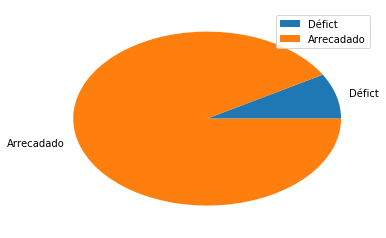

In [85]:
df_r_transpose.plot(kind="pie", subplots=True)